<a href="https://colab.research.google.com/github/yaobviously/DFSProjections/blob/master/nbamodelsipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders --quiet
!pip install shap --quiet

     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 358kB 24.2MB/s 


In [3]:
thisyear = '/content/drive/MyDrive/NBA Player Box Scores/boxscoresmay1.csv'
lastyear = '/content/drive/MyDrive/NBA Player Box Scores/lastseasonclean.csv'

teamvegasly = '/content/drive/MyDrive/NBA Player Box Scores/teamstatslastyear.csv'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance


url = 'https://raw.githubusercontent.com/yaobviously/DFSProjections/main/cleanedbox.csv'
lastseason = 'https://raw.githubusercontent.com/yaobviously/DFSProjections/main/lastseasonclean.csv'
# slate = pd.read_csv('/content/draftkings_NBA_2021-04-26_players.csv')

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [5]:
def wrangle(url):
    
    
    df = pd.read_csv(url,
                     parse_dates = ['DATE'],
                     index_col = 'DATE')
    
    df = df.rename(columns={'BIGDATABALL\nDATASET' : 'game_type',
                            'GAME-ID' : 'gameid',                            
                            'PLAYER-ID' : 'playerid',
                            'PLAYER \nFULL NAME' : 'player',
                            'POSITION' : 'position',
                            'OWN \nTEAM' : 'team', 
                            'OPPONENT \nTEAM' : 'opponent',
                            'VENUE\n(R/H)' : 'venue',
                            'STARTER\n(Y/N)' : 'starter',
                            'USAGE \nRATE (%)' : 'usage',
                            'DAYS\nREST' : 'rest',
                            'TOT' : 'totreb'})
    
    df.columns = df.columns.str.lower()
    
    df['starter'] = [1 if start == 'Y' else 0 for start in df['starter']]
    df['venue'] = df.venue.map({'H' : 1, 'R' : 0})
    
    # computing bonus points for double-doubles and triple-doubles
    
    df['dbl_digits'] = (df[['pts', 'a', 'totreb', 'st', 'bl']] >= 10).astype(int).sum(axis=1)    
    df['bonus'] = 0
    df['bonus'].loc[df['dbl_digits'] == 2] = 1.5    
    df['bonus'].loc[df['dbl_digits'] == 3] = 4.5
    
    # computing player fantasy points and game rate
    df['playerfp'] = (df['pts'] + \
                      df['a'] * 1.5 + \
                      df['totreb'] * 1.25 + \
                      df['st'] * 2 + \
                      df['bl'] * 2 + \
                      df['3p'] * 0.5 + \
                      df['to'] * -0.5 + \
                      df['bonus']
                      )
    df['gamefp36'] = ((df['playerfp'] / df['min']) * 36).round(1)
    
    # computing team fantasy points
    df['teamfp'] = df.groupby(['gameid', 'team'])['playerfp'].transform(sum)
        
       
    
    # computing running and rolling averages    
    df['gamesplayed'] = df.groupby('player')['gameid'].cumcount().shift()
    df['avgfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.expanding().mean().shift())    
    df['totmin'] = df.groupby('player')['min'].transform(lambda x: x.cumsum().shift())
    df['totfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.cumsum().shift())
    df['seasonfppm'] = (df['totfp'] / df['totmin']).round(2)
    df['ptsseason'] = df.groupby('player')['pts'].transform(lambda x: x.expanding().sum().shift())
    df['ftaseas'] = df.groupby('player')['fta'].transform(lambda x: x.expanding().sum().shift())
    df['fgaseas'] = df.groupby('player')['fga'].transform(lambda x: x.expanding().sum().shift())
    df['3paseas'] = df.groupby('player')['3pa'].transform(lambda x: x.expanding().sum().shift())
    df['3fraction'] = df['3paseas']/df['fgaseas']
    df['starter_avg'] = df.groupby('player')['starter'].transform(lambda x: x.expanding().mean().shift())
    df['starter_diff'] = df['starter'] - df['starter_avg']
    
    df['ts_season'] = (df['ptsseason'] / (2 * (df['fgaseas'] + (df['ftaseas'] * 0.44)))).round(3)
    
    df['mpg'] = df.groupby('player')['min'].transform(lambda x: x.expanding().mean().shift())
    df['rollingmpg'] = df.groupby('player')['min'].transform(lambda x:
                                                             x.rolling(3, min_periods = 1)
                                                             .mean()
                                                             .shift())
    
    df['avgusage'] = df.groupby('player')['usage'].transform(lambda x:
                                                             x.expanding()
                                                             .mean()
                                                             .shift())
    
    df['rollingusage'] = df.groupby('player')['usage'].transform(lambda x:
                                                                 x.rolling(5)
                                                                 .mean()
                                                                 .shift())  
    
    df['stdgamefp'] = df.groupby('player')['gamefp36'].transform(lambda x:
                                                                 x.expanding()
                                                                 .std()
                                                                 .shift())  
    
    df['maxfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.shift().max())
    df['minfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.shift().min())
    df['maxmin'] = df.groupby('player')['min'].transform(lambda x: x.shift().max())
    df['minmin'] = df.groupby('player')['min'].transform(lambda x: x.shift().min())    
    df['extramins'] = df['rollingmpg'] - df['mpg']
    df['extrausage'] = df['rollingusage'] - df['avgusage']
    df['league3p'] = df['3p'].expanding().sum().shift()
    df['league3pa'] = df['3pa'].expanding().sum().shift()
    df['league3perc'] = (df['league3p'] / df['league3pa']).round(3)
    
    df['starter_avg'] = df.groupby('player')['starter'].transform(lambda x: x.expanding().mean().shift())
    df['starter_diff'] = df['starter'] - df['starter_avg']
    df['did_boom'] = (df['playerfp'] >= (df['avgfp'] + 8)).astype(int)
    df['above_avg'] = (df['playerfp'] > df['avgfp']).astype(int)
    
    # dropping colums i don't need 
    
    col_drop = ['dbl_digits', 'playerid', 'ptsseason', 'ftaseas','fgaseas',
                'league3p', 'league3pa', '3paseas']   

    df.drop(col_drop, axis = 1, inplace = True)
    
    return df

In [ ]:
df = wrangle(thisyear)

In [7]:
df['gamestartersum'] = df.groupby(['gameid', 'team', 'starter'])['starter_avg'].transform(sum)

In [14]:

game_stats = ['min', 'fg', 'fga', '3p', '3pa', 'ft', 'fta', 'or', 'dr',
              'totreb', 'a', 'pf', 'st', 'to', 'bl', 'pts', 'usage',
              'bonus', 'fp36', 'teamfp', 'gameid', 'game_type',
              'gamefp36', 'above_avg', 'did_boom']


modelcol_drop = ['venue', 'avgusage', 'minfp', 'starter_avg', 'minmin', 'rest', 
                 'boomallowed', 'position']

df_model = df[df.columns.difference(game_stats + modelcol_drop)]

In [15]:
# features = ['avgfp', 'maxfp', 'rollingmpg', 'extrausage',
#             'starter_diff', 'rollingusage', 'mpg',
#             'rollextramin', 'stdgamefp', 'opponent', 'closing_spread',
#             'closing_total', 'seasonfppm', 'games', '3apercent']

# model_likes = ['maxfp', 'avgfp', 'starter_diff', 'stdgamefp', 'seasonfppm',
#                'extrausage', 'rollingusage', 'games', 'closing_total']

target = 'playerfp'

date_threshold = '2021-02-28'
mask = df_model.index < date_threshold

X = df_model.drop(target, axis = 1)
y = df_model[target]

X_train, y_train = X[mask], y[mask]
X_test, y_test = X[~mask], y[~mask]

In [10]:
baseline = abs(df['avgfp'] - df['playerfp']).mean()

print('The mean absolute error of a simple model that only uses the player average is:', baseline)

The mean absolute error of a simple model that only uses the player average is: 7.566915055708975


In [ ]:
model_xg_cf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(eval_metric = 'auc',
                  n_estimators = 55
                  )
)

model_xg_cf.fit(X_train, y_train);

In [18]:
model_xg = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBRegressor(objective = 'reg:linear')
)

model_xg.fit(X_train, y_train);

[00:05:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
estimators = np.arange(20, 150, 5)
test = []

for e in estimators: 
  model_xg_cf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(eval_metric = 'auc',
                  n_estimators = e
                  )
  )

  model_xg_cf.fit(X_train, y_train)
  auc_ = roc_auc_score(y_test, model_xg_cf.predict_proba(X_test)[:,1])
  test.append(auc_)

In [ ]:
from sklearn.metrics import roc_curve

fp, tr, thresh = roc_curve(y_test, model_xg_cf.predict_proba(X_test)[:,1])

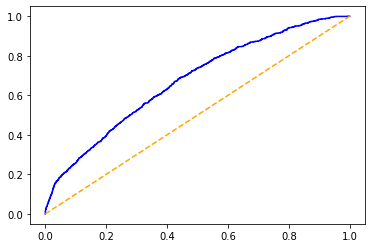

In [ ]:
plt.plot(fp, tr, c = 'blue')
plt.plot([0,1], c = 'orange', ls = '--')
plt.show()

In [ ]:
auc_score = roc_auc_score(y_test, model_xg_cf.predict_proba(X_test)[:,1])

print('The AUC for the XGB Classifier is:', auc_score)

The AUC for the XGB Classifier is: 0.6723687424820108


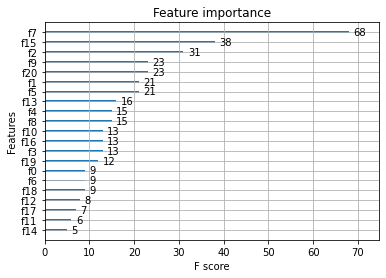

In [ ]:
plot_importance(model_xg_cf.named_steps['xgbclassifier'], importance_type = "weight")

In [19]:
mean_absolute_error(y_test, model_xg.predict(X_test))

7.331436667940051

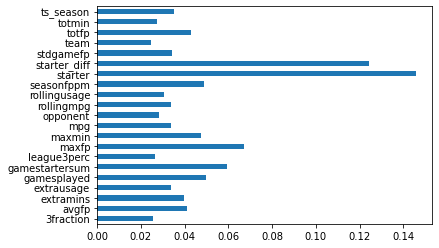

In [ ]:
features = model_xg_cf.named_steps['ordinalencoder'].get_feature_names()
importances = model_xg_cf.named_steps['xgbclassifier'].feature_importances_

pd.Series(importances, index = features).plot.barh()

In [ ]:
permb = permutation_importance(model_xg_cf, X_test, y_test, n_repeats = 5)

perm_dict = {
    'mean_imp':permb['importances_mean']
}

pd.DataFrame(perm_dict, index = X.columns).round(5).sort_values(by = 'mean_imp', ascending = False)

In [ ]:
df['pred_boom'] = model_xg_cf.predict_proba(df[features])[:,1]

In [ ]:
df[df['player'] == 'Andre Drummond'][['playerfp', 'pred_boom', 'did_boom']].sort_values(by = 'pred_boom', ascending = False).head(30)

,playerfp,pred_boom,did_boom
DATE,,,
2021-01-15,74.75,0.364408,1
2021-01-11,46.50,0.344130,0
2021-01-20,26.25,0.340224,0
2020-12-26,64.00,0.327906,1
2021-02-10,13.00,0.327108,0
2021-01-31,62.50,0.308095,1
2021-02-12,18.75,0.290803,0
2021-01-27,59.50,0.283885,1
2021-01-06,42.25,0.283126,0


In [ ]:
slate = pd.read_csv('/content/fcapril27.csv')
slate.columns = slate.columns.str.lower()

In [ ]:
projection_filter = features + ['player', 'starter_avg']

projection_filter

In [ ]:
todayplayers = slate['player'].unique()

In [ ]:
predict_today = df[df['player'].isin(todayplayers)].groupby('player')[projection_filter].tail(1)

predict_today['boom_proba'] = model_xg_cf.predict_proba(predict_today[features])[:,1]

In [ ]:
predict_today.to_csv('today.csv')

In [ ]:
predict_today.sort_values(by = 'boom_proba', ascending = False, inplace = True)

project_today = pd.merge(predict_today, slate[['player', 'proj mins']], how = 'left', on = 'player')

project_today.drop(columns = 'rollingmpg', inplace = True)

project_today.rename(columns = {'proj mins' : 'rollingmpg'}, inplace = True)

project_today['boom_proba'] = model_xg_cf.predict_proba(project_today[features])[:,1]

In [ ]:
project_today.sort_values(by = 'boom_proba', ascending = False).head(30)

In [ ]:
project_today.to_csv('project_today.csv')

features_reg = model_xg.named_steps['ordinalencoder'].get_feature_names()

In [ ]:
project_today_two = pd.read_csv('/content/project_today - project_today.csv')
project_today_two['starter_diff'] = project_today_two['starter'] - project_today_two['starter_avg']
project_today_two['boom_proba'] = model_xg_cf.predict_proba(project_today_two[features])[:,1]

project_today_two['projection'] = model_xg.predict(project_today_two[features_reg])

In [ ]:
project_today_two = project_today_two.round(3)

project_today_two.to_csv('done2.csv')

project_today_two

,Unnamed: 0,3fraction,avgfp,extramins,extrausage,gamesplayed,gamestartersum,league3perc,maxfp,maxmin,mpg,opponent,rollingusage,seasonfppm,starter,starter_diff,stdgamefp,team,totfp,totmin,ts_season,player,starter_avg,boom_proba,rollingmpg,projection
0,1,0.806,7.971,9.845,-0.103,52,1.194,0.367,44.00,27.45,10.555,Oklahoma City,14.914,0.76,1,0.962,31.526,Toronto,207.25,274.43,0.735,Paul Watson,0.038,0.559,0.00,18.093000
1,7,0.110,16.577,8.042,1.165,48,4.182,0.367,52.25,36.58,20.655,Cleveland,13.598,0.80,1,0.818,10.929,Toronto,911.75,1136.03,0.530,Khem Birch,0.182,0.408,30.00,27.547001
2,36,0.262,40.745,2.792,3.536,39,4.182,0.367,65.25,43.03,35.731,Cleveland,29.510,1.14,1,0.000,10.342,Toronto,1955.75,1715.11,0.552,Pascal Siakam,1.000,0.261,34.75,43.962002
3,47,0.549,39.888,-3.441,-1.741,55,4.182,0.367,77.75,41.42,36.158,Cleveland,22.256,1.10,1,0.000,10.579,Toronto,1874.75,1699.42,0.543,Fred VanVleet,1.000,0.246,34.25,45.084999
4,51,0.520,30.321,2.657,3.028,20,4.182,0.367,53.50,40.87,33.190,Cleveland,21.968,0.91,1,0.000,8.563,Toronto,1182.50,1294.41,0.610,OG Anunoby,1.000,0.238,34.25,27.674999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,156,0.712,7.706,-2.659,2.005,52,1.403,0.367,21.50,28.65,12.722,Charlotte,17.306,0.61,0,0.000,16.904,Boston,262.00,432.55,0.513,Aaron Nesmith,0.000,0.099,9.75,7.342000
181,159,0.000,8.404,-2.009,-2.951,40,1.011,0.367,18.75,19.17,6.995,Philadelphia,16.868,1.20,0,0.000,26.045,Boston,109.25,90.94,0.662,Tacko Fall,0.000,0.090,0.00,6.196000
182,160,0.333,7.023,7.866,-2.914,23,1.403,0.367,15.75,31.82,16.124,Charlotte,8.564,0.44,0,-0.273,9.391,Boston,77.25,177.36,0.350,Romeo Langford,0.273,0.093,15.75,6.950000
183,162,0.439,8.015,-2.812,8.180,11,1.403,0.367,22.00,24.28,7.285,Charlotte,30.008,1.10,0,-0.059,29.161,Boston,136.25,123.85,0.530,Tremont Waters,0.059,0.088,0.00,5.844000
